# Statsmodels: Temporal Analysis

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import ruptures as rpt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.datasets import load_airline, load_macroeconomic
from pmdarima.arima import ndiffs
from scipy.signal import argrelmin, argrelmax, find_peaks

plt.style.use(['seaborn', 'seaborn-whitegrid'])
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

## 1. Time series manipulation

### 1.1. Datetime manipulation

In [1]:
import numpy as np
import pandas as pd

#### Standard format
The complete datetime has the data type of `datetime64` and the format can be either `YYYY-MM-DD` or `YYYY-MM-DD hh:mm:ss`. This column can be used to detach year, quarter, month,... and the cyclic fields.

To quickly create a date or time column, use the `pd.date_range()` function with the `freq` parameter indicating the frequency of the date. The `freq` parameter support a number of [aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).

In [8]:
seqMS = pd.date_range('2020-01-01', '2020-12-31', freq='MS')[:5]
seq3h = pd.date_range('2020-01-01', '2020-12-31', freq='3h')[:5]
pd.DataFrame({
    'month_start': seqMS,
    'time_3h': seq3h,
})

month_start             time_3h
0  2020-01-01 2020-01-01 00:00:00
1  2020-02-01 2020-01-01 03:00:00
2  2020-03-01 2020-01-01 06:00:00
3  2020-04-01 2020-01-01 09:00:00
4  2020-05-01 2020-01-01 12:00:00

#### Useful techniques

In [4]:
dfDate = pd.DataFrame({
    'day': [1, 2, 3],
    'month': [1, 1, 1],
    'year': [2020, 2020, 2020]
})

# combine three columns "day", "month" and "year"
dfDate.assign(date=pd.to_datetime(dfDate[['day', 'month', 'year']]))

day  month  year       date
0    1      1  2020 2020-01-01
1    2      1  2020 2020-01-02
2    3      1  2020 2020-01-03

In [5]:
sequence = pd.date_range('2020-01-01', '2020-12-31', freq='17h 36t 43s')
dfDate = pd.DataFrame({'time': sequence}).head()
dfDate.assign(date=dfDate.time.dt.date)

time        date
0 2020-01-01 00:00:00  2020-01-01
1 2020-01-01 17:36:43  2020-01-01
2 2020-01-02 11:13:26  2020-01-02
3 2020-01-03 04:50:09  2020-01-03
4 2020-01-03 22:26:52  2020-01-03

#### Formatting date

In [6]:
dfDate = pd.DataFrame({'date': pd.date_range('2020-01-01', '2020-12-31', freq='25D')})
dfDate.assign(date_print=dfDate.date.dt.strftime('%d/%m/%y')).head()

date date_print
0 2020-01-01   01/01/20
1 2020-01-26   26/01/20
2 2020-02-20   20/02/20
3 2020-03-16   16/03/20
4 2020-04-10   10/04/20

#### Extracting date part

In [7]:
dfDate = pd.DataFrame({'date': pd.date_range('2020-01-01', '2020-12-31', freq='100000 min')})

dfDate\
    .assign(year=dfDate.date.dt.to_period('Y').astype(str))\
    .assign(quarter=dfDate.date.dt.to_period('Q').astype(str).str.replace('Q', '-'))\
    .assign(month=dfDate.date.dt.to_period('M').astype(str))\
    .assign(week=dfDate.date.dt.strftime('%Y-%U'))

date  year quarter    month     week
0 2020-01-01 00:00:00  2020  2020-1  2020-01  2020-00
1 2020-03-10 10:40:00  2020  2020-1  2020-03  2020-10
2 2020-05-18 21:20:00  2020  2020-2  2020-05  2020-20
3 2020-07-27 08:00:00  2020  2020-3  2020-07  2020-30
4 2020-10-04 18:40:00  2020  2020-4  2020-10  2020-40
5 2020-12-13 05:20:00  2020  2020-4  2020-12  2020-50

#### Extracting cyclic attributes

In [8]:
dfDate = pd.DataFrame({'date': pd.date_range('2020-01-01', '2020-12-31', freq='100000 min')})

dfDate\
    .assign(weekday=dfDate.date.dt.day_name())\
    .assign(day_of_year=dfDate.date.dt.dayofyear)\
    .assign(month_of_year=dfDate.date.dt.month)\
    .assign(quarter_of_year=dfDate.date.dt.quarter)

date    weekday  day_of_year  month_of_year  quarter_of_year
0 2020-01-01 00:00:00  Wednesday            1              1                1
1 2020-03-10 10:40:00    Tuesday           70              3                1
2 2020-05-18 21:20:00     Monday          139              5                2
3 2020-07-27 08:00:00     Monday          209              7                3
4 2020-10-04 18:40:00     Sunday          278             10                4
5 2020-12-13 05:20:00     Sunday          348             12                4

#### Rounding date
The `freq` parameter of the `Series.dt.round()` method uses the same aliases mentioned earlier.

In [9]:
dfDate = pd.DataFrame({'date': pd.date_range('2020-01-01', '2020-12-31', freq='100000 min')})
dfDate.assign(date_trunc=dfDate.date.dt.round(freq='h'))

date          date_trunc
0 2020-01-01 00:00:00 2020-01-01 00:00:00
1 2020-03-10 10:40:00 2020-03-10 11:00:00
2 2020-05-18 21:20:00 2020-05-18 21:00:00
3 2020-07-27 08:00:00 2020-07-27 08:00:00
4 2020-10-04 18:40:00 2020-10-04 19:00:00
5 2020-12-13 05:20:00 2020-12-13 05:00:00

However, the `Series.dt.round()` method only works with fixed frequencies such as hour, minute, second. For rounding to date or month, use the `Series.dt.to_period()` method.

In [11]:
dfDate = pd.DataFrame({'date': pd.date_range('2020-01-01', '2020-12-31', freq='100000 min')})
dfDate.assign(date_trunc=dfDate.date.dt.to_period('M').dt.to_timestamp())

date date_trunc
0 2020-01-01 00:00:00 2020-01-01
1 2020-03-10 10:40:00 2020-03-01
2 2020-05-18 21:20:00 2020-05-01
3 2020-07-27 08:00:00 2020-07-01
4 2020-10-04 18:40:00 2020-10-01
5 2020-12-13 05:20:00 2020-12-01

#### Timedelta

In [9]:
dfDelta = pd.DataFrame({
    'date1': pd.date_range('2020-01-01', '2020-01-31', freq='3D'),
    'date2': pd.date_range('2020-01-02', '2020-03-15', freq='W')
})
dfDelta['timedelta'] = dfDelta.date2 - dfDelta.date1
dfDelta['date3'] = dfDelta.date1 + pd.Timedelta('15 days')
dfDelta

date1      date2 timedelta      date3
0  2020-01-01 2020-01-05    4 days 2020-01-16
1  2020-01-04 2020-01-12    8 days 2020-01-19
2  2020-01-07 2020-01-19   12 days 2020-01-22
3  2020-01-10 2020-01-26   16 days 2020-01-25
4  2020-01-13 2020-02-02   20 days 2020-01-28
5  2020-01-16 2020-02-09   24 days 2020-01-31
6  2020-01-19 2020-02-16   28 days 2020-02-03
7  2020-01-22 2020-02-23   32 days 2020-02-06
8  2020-01-25 2020-03-01   36 days 2020-02-09
9  2020-01-28 2020-03-08   40 days 2020-02-12
10 2020-01-31 2020-03-15   44 days 2020-02-15

### 1.2. Time series filling
A time series may have no existing blank value, however, it doesn't mean that date column is completed. A completed time series requires all data points to be equally spaced. In other words, the date or time frequency should be a constant across the dataset. Interpolation (the process of inferring new values from given ones) is a great technique filling missing time series.

In [1]:
import numpy as np
import pandas as pd

In [3]:
dfPrice = pd.DataFrame({
    'date': pd.to_datetime([
        '2020-01-01', '2020-01-03', '2020-01-04', '2020-01-05',
        '2020-01-06', '2020-01-07', '2020-01-09', '2020-01-10'
    ]),
    'price': [110, 113, 112, 115, 118, 120, 118, 116]
})

#### Unhiding missing data

In [4]:
dfPrice = dfPrice.set_index('date').asfreq('d').reset_index()
dfPrice

date  price
0 2020-01-01  110.0
1 2020-01-02    NaN
2 2020-01-03  113.0
3 2020-01-04  112.0
4 2020-01-05  115.0
5 2020-01-06  118.0
6 2020-01-07  120.0
7 2020-01-08    NaN
8 2020-01-09  118.0
9 2020-01-10  116.0

#### Neighbor filling
Two approaches:
- Foward filling: $y_t\leftarrow y_{t-1}$
- Backward filling: $y_t\leftarrow y_{t+1}$

In [5]:
forward = dfPrice.price.fillna(method='ffill')
backward = dfPrice.price.fillna(method='bfill')
dfPrice.assign(forward=forward, backward=backward)

date  price  forward  backward
0 2020-01-01  110.0    110.0     110.0
1 2020-01-02    NaN    110.0     113.0
2 2020-01-03  113.0    113.0     113.0
3 2020-01-04  112.0    112.0     112.0
4 2020-01-05  115.0    115.0     115.0
5 2020-01-06  118.0    118.0     118.0
6 2020-01-07  120.0    120.0     120.0
7 2020-01-08    NaN    120.0     118.0
8 2020-01-09  118.0    118.0     118.0
9 2020-01-10  116.0    116.0     116.0

#### Linear interpolating
This is a family of interpolation, where the simplest strategy is:

$$y_t\leftarrow \frac{y_{t-1}+y_{t+1}}{2}$$

In [20]:
filled_values = dfPrice.price.interpolate(method='linear')
dfPrice.assign(price=filled_values)

date  price
0 2020-01-01  110.0
1 2020-01-02  111.5
2 2020-01-03  113.0
3 2020-01-04  112.0
4 2020-01-05  115.0
5 2020-01-06  118.0
6 2020-01-07  120.0
7 2020-01-08  119.0
8 2020-01-09  118.0
9 2020-01-10  116.0

### 1.3. Time series calculation

In [21]:
import pandas as pd
import numpy as np

#### Cumulative sum
[Cumulative sum] is the discrete version of [antiderivative], the transformed series $\mathbf{y}'$ satisfies:

$$y'_t=y_1+y_2+\dots+y_t$$

[Cumulative sum]: https://en.wikipedia.org/wiki/Running_total
[antiderivative]: https://en.wikipedia.org/wiki/Antiderivative

In [22]:
dfPurchase = pd.DataFrame({
    'date': pd.date_range(start='1/1/2000', periods=12),
    'quantity': [10, 13, 11, 12, 8, 9, 9, 11, 10, 11, 13, 14]
})

dfPurchase['quantity_cumulative'] = dfPurchase.quantity.cumsum()
dfPurchase

date  quantity  quantity_cumulative
0  2000-01-01        10                   10
1  2000-01-02        13                   23
2  2000-01-03        11                   34
3  2000-01-04        12                   46
4  2000-01-05         8                   54
5  2000-01-06         9                   63
6  2000-01-07         9                   72
7  2000-01-08        11                   83
8  2000-01-09        10                   93
9  2000-01-10        11                  104
10 2000-01-11        13                  117
11 2000-01-12        14                  131

#### Differencing
[Differencing] is the discrete version of [derivative], in which the transformed series $\mathbf{y}'$ is given by:

$$y_t'=y_t-y_{t-1}$$

[Differencing]: https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average#Differencing
[derivative]: https://en.wikipedia.org/wiki/Derivative

In [6]:
import numpy as np
import pandas as pd

In [7]:
dfPurchase = pd.DataFrame({
    'date': pd.date_range(start='1/1/2000', periods=12),
    'quantity': [10, 13, 11, 12, 8, 9, 9, 11, 10, 11, 13, 14]
})

dfPurchase['quantity_difference'] = dfPurchase.quantity.diff(periods=2)
dfPurchase.head(10)

date  quantity  quantity_difference
0 2000-01-01        10                  NaN
1 2000-01-02        13                  NaN
2 2000-01-03        11                  1.0
3 2000-01-04        12                 -1.0
4 2000-01-05         8                 -3.0
5 2000-01-06         9                 -3.0
6 2000-01-07         9                  1.0
7 2000-01-08        11                  2.0
8 2000-01-09        10                  1.0
9 2000-01-10        11                  0.0

#### Moving average
Given a series (which has $N$ observations), [moving average] or rolling mean calculate the average of each pre-selected size window. A window of size $K$ (which implies the order of moving average) means $K$ consecutive values is taken into calculating the mean. Rolling mean is used on time series data to smooth the short-term fluctuations and highlight long-term trends and cycles. Some examples of commonly used values of $K$:
- For a date series, $K=7$ (weekly) or $K=30$ (monthly).
- For a month series, $K=4$ (quarterly) or $K=12$ (annual).

[moving average]: https://en.wikipedia.org/wiki/Moving_average

In [1]:
import numpy as np
import pandas as pd

In [3]:
dfRate = pd.read_csv('../data/exchange_rate.csv')

dfRate['rate_smooth'] = dfRate.rate.rolling(window=7, center=True).mean()
dfRate.head(10)

date     rate   rate_smooth
0  2020-02-28  23241.0           NaN
1  2020-02-27  23241.5           NaN
2  2020-02-26  23241.0           NaN
3  2020-02-25  23271.0  23246.285714
4  2020-02-24  23248.5  23244.428571
5  2020-02-23  23243.5  23244.714286
6  2020-02-22  23237.5  23243.071429
7  2020-02-21  23228.0  23239.500000
8  2020-02-20  23243.5  23238.285714
9  2020-02-19  23229.5  23239.928571

Notice that there will be $N-K+1$ rolling mean points and $K-1$ null values. Therefore, if $K$ is even, then the rolling mean cannot be centered. To avoid this problem, calculate the rolling mean once again with the order of 2.

In [49]:
dfRate = pd.read_csv('../data/exchange_rate.csv')

rate = dfRate.rate
ma6 = rate.rolling(window=6, center=True).mean()
ma6x2 = ma6.rolling(window=2).mean().shift(-1)

dfRate['rate_smooth'] = ma6x2
dfRate.head(10)

date     rate   rate_smooth
0  2020-02-28  23241.0           NaN
1  2020-02-27  23241.5           NaN
2  2020-02-26  23241.0           NaN
3  2020-02-25  23271.0  23247.458333
4  2020-02-24  23248.5  23246.041667
5  2020-02-23  23243.5  23245.125000
6  2020-02-22  23237.5  23241.875000
7  2020-02-21  23228.0  23238.208333
8  2020-02-20  23243.5  23237.708333
9  2020-02-19  23229.5  23238.875000

#### Growth rate
The formula for growth rate is given by:

$$r_t=\frac{y_t-y_{t-1}}{y_{t-1}}$$

In [28]:
import numpy as np
import pandas as pd

In [29]:
dfCpi = pd.DataFrame({
    'quarter': [f'{year} Q{quarter}' for year in range(2017,2020) for quarter in range(1,5)],
    'cost': [111.63, 112.23, 112.68, 113.10, 114.10, 115.28, 115.66, 115.59, 115.98, 117.37, 117.69, 117.94]
})

dfCpi['growth_over_last_period'] = dfCpi.cost.pct_change().map('{:.2%}'.format)
dfCpi['growth_over_same_period_last_year'] = dfCpi.cost.pct_change(periods=4).map('{:.2%}'.format)
dfCpi

quarter    cost growth_over_last_period growth_over_same_period_last_year
0   2017 Q1  111.63                    nan%                              nan%
1   2017 Q2  112.23                   0.54%                              nan%
2   2017 Q3  112.68                   0.40%                              nan%
3   2017 Q4  113.10                   0.37%                              nan%
4   2018 Q1  114.10                   0.88%                             2.21%
5   2018 Q2  115.28                   1.03%                             2.72%
6   2018 Q3  115.66                   0.33%                             2.64%
7   2018 Q4  115.59                  -0.06%                             2.20%
8   2019 Q1  115.98                   0.34%                             1.65%
9   2019 Q2  117.37                   1.20%                             1.81%
10  2019 Q3  117.69                   0.27%                             1.76%
11  2019 Q4  117.94                   0.21%                             2.03%

## 2. Time series analysis
In this section, we discuss possible characteristics that can be observed from a [time series]:
- *Trend*, the long-term change of data (increasing or decreasing) without looking at small fluctuations.
- *Seasonality*, the pattern that repeats after a specific period.
- *Cyclic*, very much like seasonality but the length of each cycle is not fixed.

[time series]: https://en.wikipedia.org/wiki/Time_series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use(['seaborn', 'seaborn-whitegrid'])
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### 2.1. Notation

#### Time series notation
It's important to introduce time series notations:
- $\mathbf{y}=(y_1,y_2,\dots,y_t,\dots,y_T)$ represents the entire series
- $y_t$ (for $t=1,2,\dots,T$) represents an observation, $t$ represents any observed time step
- $\hat{y}_{T+h}$ (for $h=1,2,\dots,\infty$) is an unknown future value which is going to be forecasted, $h$ is the forecasting horizon
- $\hat{y}_{T+h|T}$ is the forecast value $\hat{y}_{T+h}$ taking into account all observations up to time $T$

#### Backshift notation
Now we have walked through all important time series transformations: shifting, differencing and summing, let's introduce the *backshift* notation $B$, an operator that shifts our series 1 step backward. We define $B(\mathbf{y})=(\emptyset,y_1,y_2,\dots,y_{t-1},\dots,y_{T-1})$. We are going to use $B$ to describe different transformations of a simple series $\mathbf{y}=(10,12,15,16,20)$.

*Shifting*
- By definition, $B(\mathbf{y})=(\emptyset,10,12,15,16)$
- $B^2(\mathbf{y})=B(B(\mathbf{y}))=(\emptyset,\emptyset,10,12,15)$ represents the 2-step lagged series
- $B^k(\mathbf{y})$ represents a $k$-step lagged series

*Differencing*
- $(1-B)(\mathbf{y})=\mathbf{y}-B(\mathbf{y})=(\emptyset,2,3,1,4)$ represents the 1-order differenced series
- $(1-B)^2(\mathbf{y})=(\mathbf{y}-B(\mathbf{y}))-B(\mathbf{y}-B(\mathbf{y}))=(\emptyset,\emptyset,1,-2,3)$ represents the 2-order differenced series
- $(1-B)^k(\mathbf{y})$ represents a $k$-order differenced series

*Running total*
- Denotes $\mathbf{z}=(10,22,37,53,73)$ the cumulative sum of $\mathbf{y}$, then $(1-B)(\mathbf{z})=(\emptyset,12,15,16,20)=\mathbf{y}$
- Rewriting the above equation gives us $(1-B)^{-1}(\mathbf{y})$ the representation of cumulative sum, can also be thought as the inverse of differencing

### 2.2. Auto correlation
When identifying possible relationship between historical data and the current moment, there are two useful functions, each is plotted in a lollipop chart:
- ACF (Auto-Correlation Function). It plots the Pearson's correlation coefficients $\rho_1,\rho_2,\dots$ of a series $\mathbf{y}$ against each of its lagged versions. That is to say, $\rho_1$ measures how $B(\mathbf{y})$ affects $\mathbf{y}$. For $\rho_2$, it actually measures the total effect of both $B^2(\mathbf{y})$ and $B(\mathbf{y})$ on $\mathbf{y}$, since $B^2(\mathbf{y})$ and $B(\mathbf{y})$ are also correlated. This explains why the ACF chart is usually smooth.
- PACF (Partial ACF). It plots the coefficients $\beta_1,\beta_2,\dots$ of the OLS regression function
$\mathbf{y}=\beta_0+\beta_1B(\mathbf{y})+\beta_2B^2(\mathbf{y})+\dots$
PACF describes the direct effect $\beta_k$ made by previous data $B^k(\mathbf{y})$, since the later effects has been captured by the corresponding coefficients $(\beta_1,\beta_2,\dots,\beta_{k-1})$. This overcomes the cumulative effect in ACF.

Both ACF and PACF include a $95\%$ confidence band indicating the correlation coefficient is not significant if it falls into that band.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.datasets import load_airline, load_macroeconomic
import warnings

plt.style.use(['seaborn', 'seaborn-whitegrid'])
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [4]:
def plot_time_series(series):
    mosaic = [
        ['ts',  'ts'  ],
        ['acf', 'pacf']
    ]
    fig, ax = plt.subplot_mosaic(mosaic, figsize=(10, 6), constrained_layout=True)
    series.plot(ax=ax['ts'], title='Original series')
    plot_acf(series, ax=ax['acf'])
    plot_pacf(series, ax=ax['pacf'])
    plt.show()

In the next part, we are plotting the time series plot along with ACF and PACF for some different series. They help us finding possible trends or seasonality in the data.

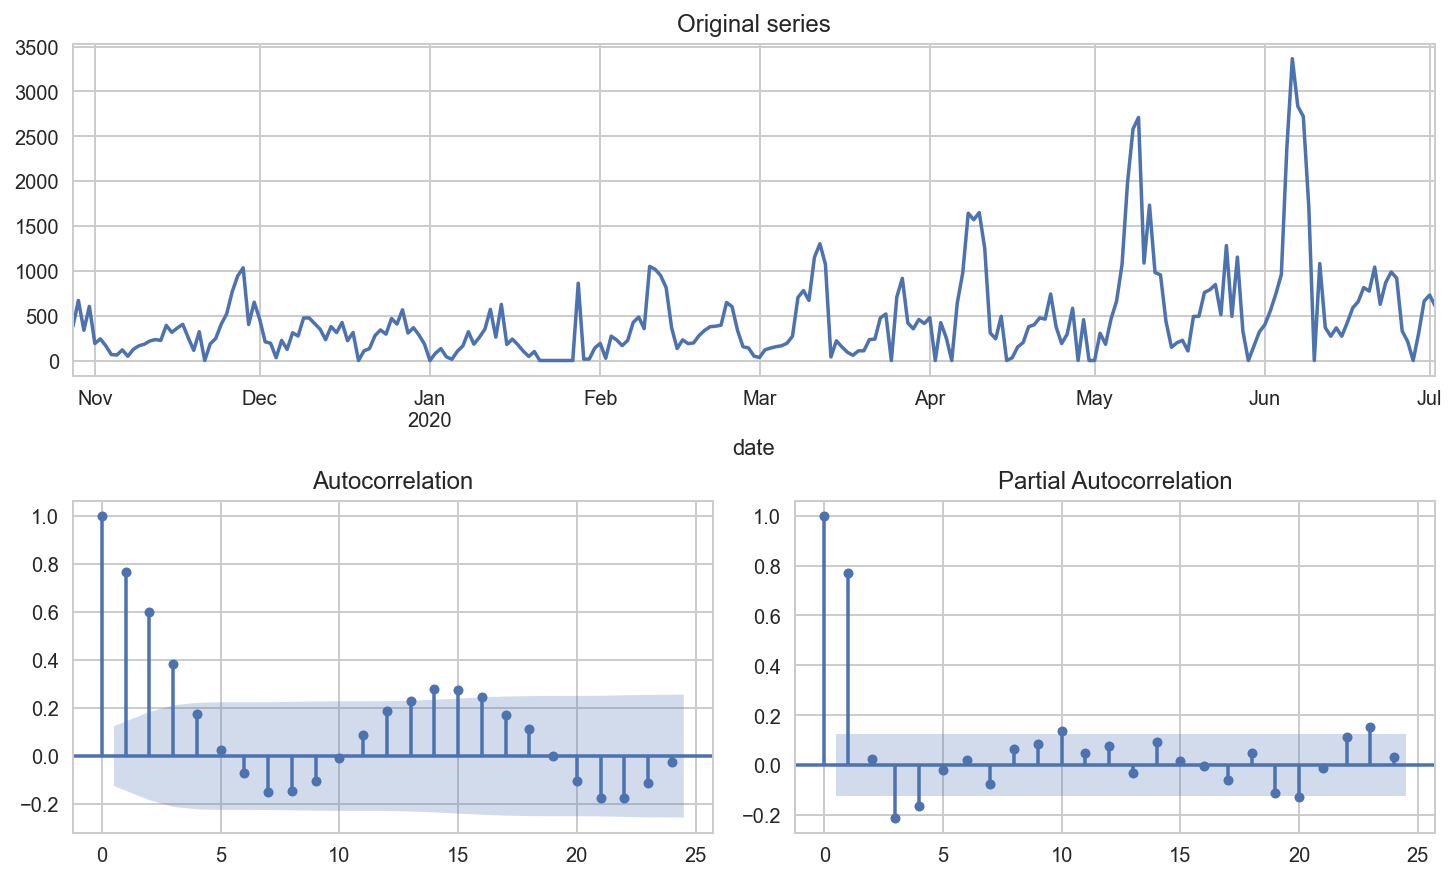

In [64]:
dfQty = pd.read_csv('../data/purchase_quantity.csv', index_col='date')
dfQty.index = dfQty.index.astype('datetime64[ns]').to_period('D')
# dfQty = dfQty.asfreq('D')

plot_time_series(dfQty.quantity)

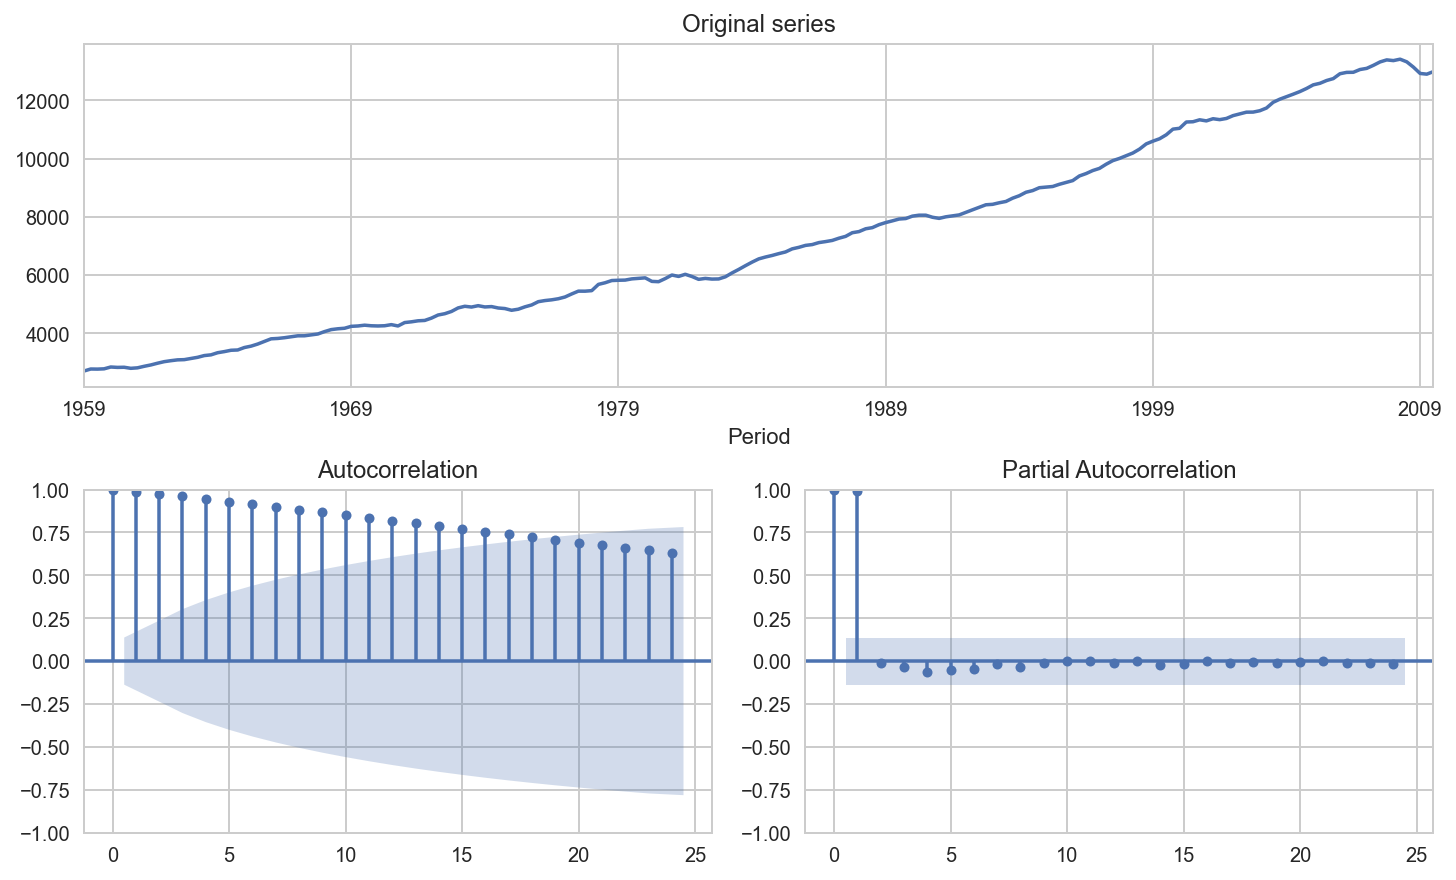

In [16]:
dfEco = load_macroeconomic()
plot_time_series(dfEco.realgdp)

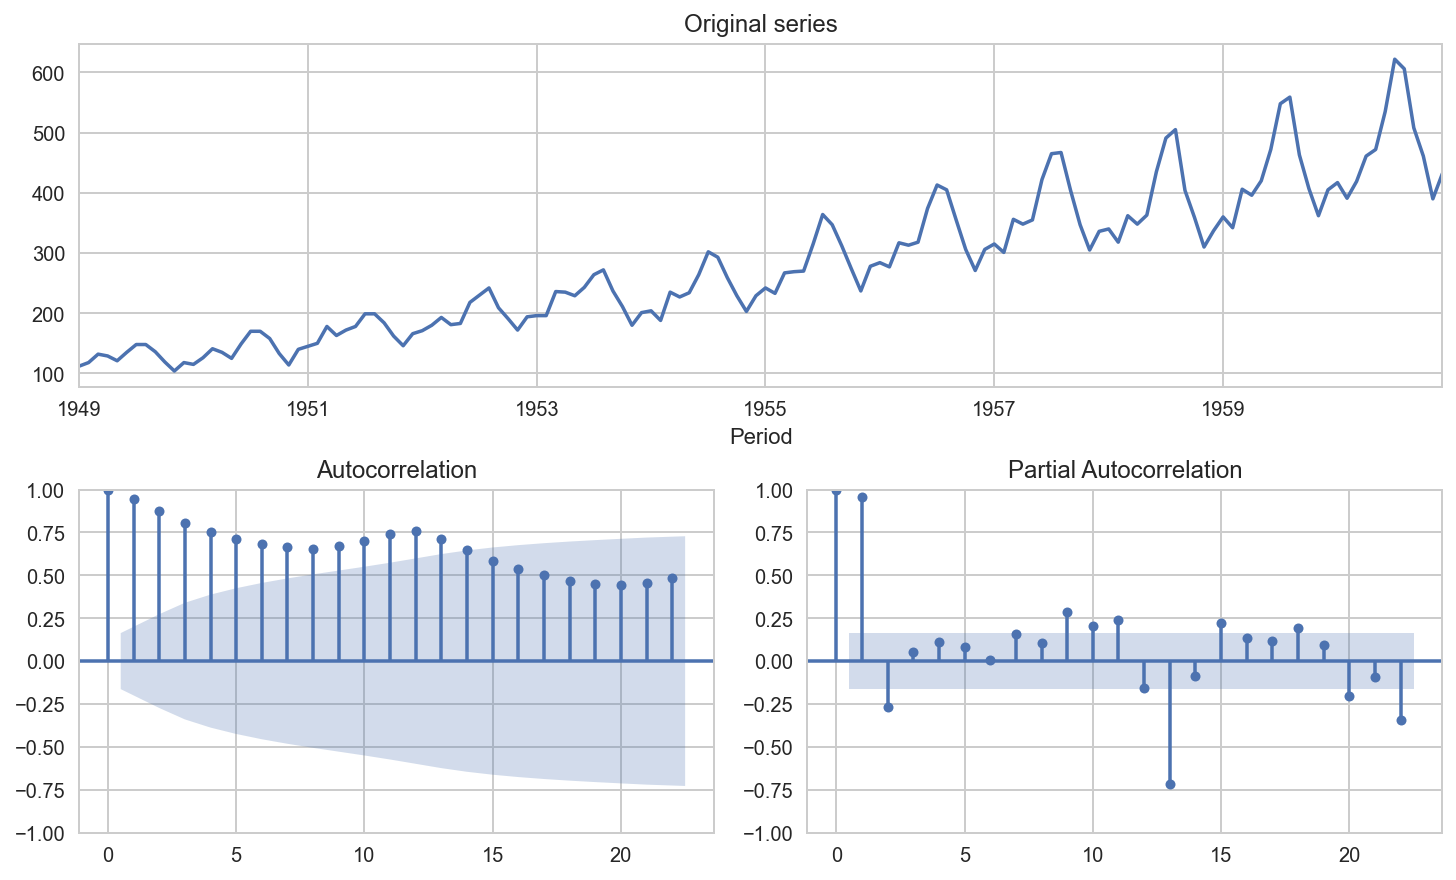

In [24]:
dfAirline = load_airline()
plot_time_series(dfAirline)

### 2.3. Seasonal decomposition
Time series decompostion is a statistical technique that factorizes data into three components: trend, residual and noise. There are two approaches to achieve this, using an additive model or a multiplicative model, where the original data equals to the sum or the product of its componennts.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [17]:
dfQuantity = pd.read_csv('../data/purchase_quantity.csv')
dfQuantity = dfQuantity.assign(date=dfQuantity.date.astype('datetime64'))
dfQuantity['quantity'] = dfQuantity.quantity.fillna(1e-6) + 1e-6
dfQuantity.head()

date    quantity
0 2019-10-28  379.490001
1 2019-10-29  669.510001
2 2019-10-30  337.170001
3 2019-10-31  603.740001
4 2019-01-11  189.820001

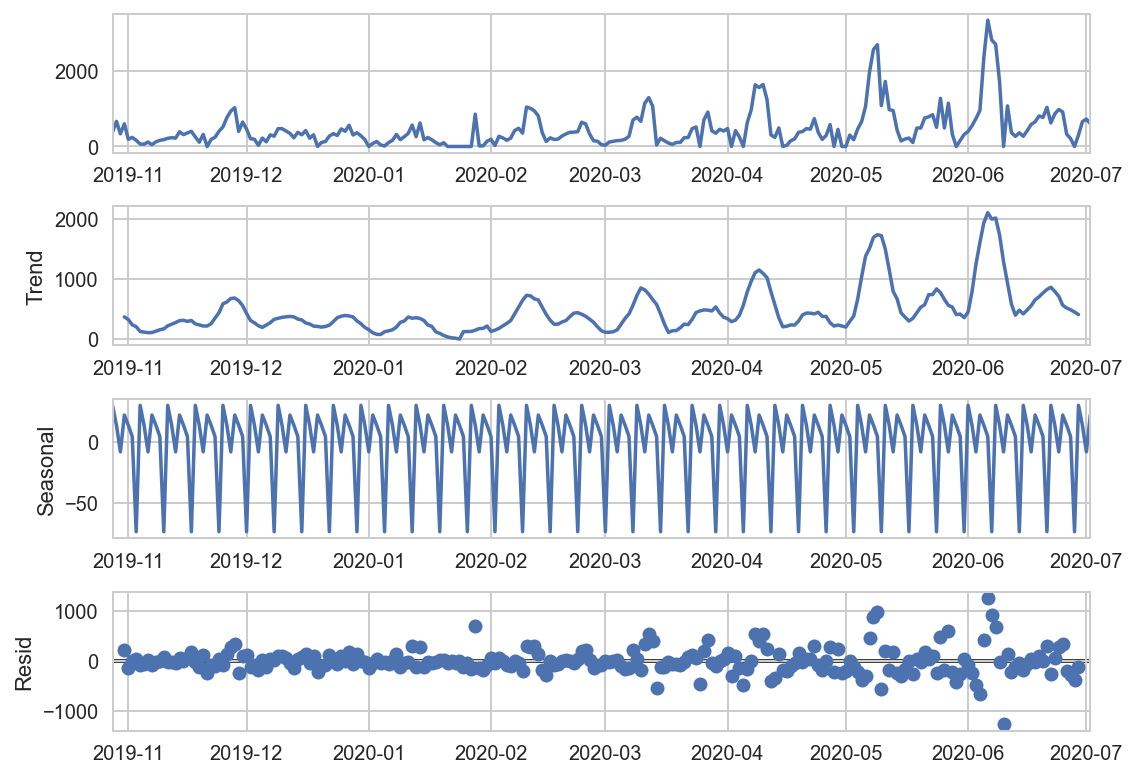

In [3]:
df = dfQuantity.copy()
df = df.set_index('date')
decomposer = seasonal_decompose(df, model='additive', period=7)
decomposer.plot()
plt.show()

In [7]:
decomposer.seasonal.head(7)

date
2019-10-28    29.471737
2019-10-29    13.227030
2019-10-30    -8.377718
2019-10-31    21.559084
2019-11-01    13.299370
2019-11-02     4.106962
2019-11-03   -73.286467
Name: seasonal, dtype: float64

### 2.4. Stationarity
Stationarity refers to a time series whose characteristics do not depends on which time period it is observed. If a time series violates one of these conditions, it is considered non-stationary:
- Constant mean at every timeframe
- Constant variance at every timeframe
- No seasonality

To check whether a time series is stationary, we can look at its line chart. Let's plot some examples:

:::{image} ../image/stationary.png
:height: 500px
:align: center
:::
<br>

- Series (d), (h), (i) have seasonality
- Series (a), (c), (e), (f), (i) have trends, thus their means at different periods are not constants
- Series (i) has increasing variance over time
- Ruling out all violated series above leaves only (b) and (g) stationary

#### Dickey-Fuller test
Instead of looking at charts, [Agumented Dickey-Fuller] test can be used to decide if a series is stationary. The hypotheses:
- $H_0$: data is non-stationary
- $H_1$: data is stationary

The decision making process is: if either p-value < significance level or test statistic < critical value, we reject $H_0$ and conclude that our data is stationary.

[Agumented Dickey-Fuller]: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [7]:
dfQuantity = pd.read_csv('../data/purchase_quantity.csv')
dfQuantity = dfQuantity.assign(date=dfQuantity.date.astype('datetime64'))
dfQuantity['quantity'] = dfQuantity.quantity.fillna(1e-6) + 1e-6
quantity = dfQuantity.set_index('date')

In [5]:
def StationaryTest(s):
    from statsmodels.tsa.stattools import adfuller
    stat, pval, _, _, crits, _ = adfuller(s, regression='nc')
    result = pval < 0.05
    
    conclusion = 'stationary' if result else 'non-stationary'
    sign = '<' if result else '>'
    
    mess = f'p-value={pval:6f} {sign} 0.05 | data is {conclusion}'
    print(mess)

In [ ]:
StationaryTest(quantity)

p-value=0.157594 > 0.05 | data is non-stationary


In [ ]:
StationaryTest(np.log(quantity))

p-value=0.000130 < 0.05 | data is stationary


In [ ]:
StationaryTest(quantity.diff(periods=1)[1:])

p-value=0.000000 < 0.05 | data is stationary


#### Differencing estimation

In [5]:
import numpy as np
import pandas as pd
from pmdarima.arima import ndiffs

In [4]:
dfQuantity = pd.read_csv('../data/purchase_quantity.csv')
dfQuantity = dfQuantity.assign(date=dfQuantity.date.astype('datetime64'))
dfQuantity['quantity'] = dfQuantity.quantity.fillna(1e-6) + 1e-6
quantity = dfQuantity.set_index('date')

In [10]:
ndiffs(quantity, test='kpss') # other test: adf, pp

1

## 3. Annotation

### 3.1. Peaks finding
The functions [`argrelmin()`] and [`argrelmax()`] find the *relative* or *local* extrema in a sequence, consider a number of points in each side for comparison.

[`argrelmin()`]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmin.html
[`argrelmax()`]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmax.html

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelmin, argrelmax, find_peaks

plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [46]:
dfQty = pd.read_csv('../data/purchase_quantity.csv')
dfQty['date'] = pd.to_datetime(dfQty['date'], format='%d/%m/%Y')
dfQty = dfQty.set_index('date').asfreq('d').fillna(0)
sQty = dfQty.quantity[150:]

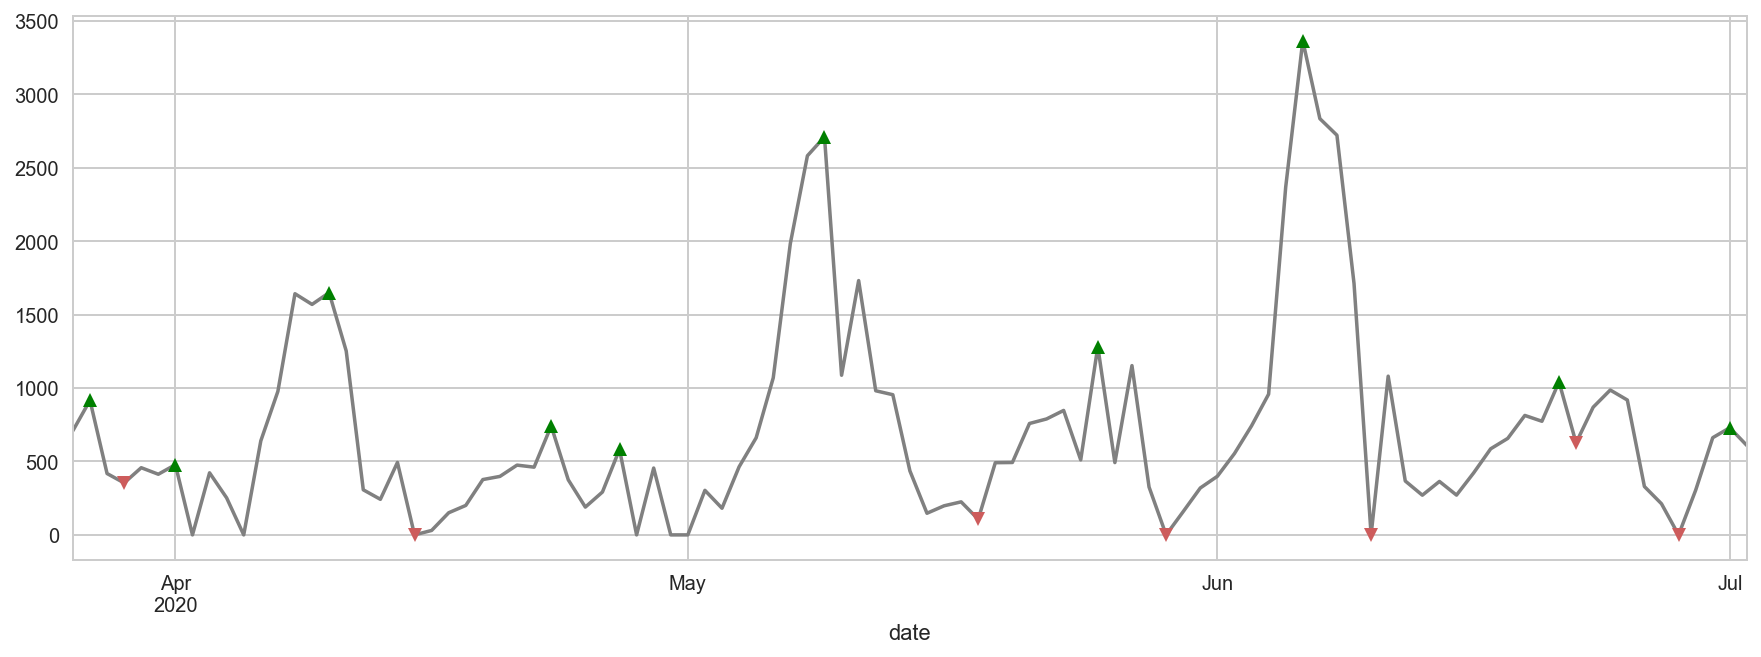

In [63]:
idxPeak = argrelmax(sQty.values, order=3)[0]
idxValley = argrelmin(sQty.values, order=3)[0]

fig, ax = plt.subplots(figsize=(15,5))
sQty.plot(color='grey')
sQty[idxValley].plot(style='v', lw=10, color='indianred')
sQty[idxPeak].plot(style='^', lw=10, color='green')
plt.show()

### 3.2. Change detection
[Ruptures] is a library for offline [change detection], which is more of an retrospective tool rather than an online method that detects changes as soon as possible. Ruptures expresses detectors as the combination of two components:
- Cost function, which defines the type of change (in trends, variance or distribution), which is important in unsupervised problems
- Search method, which refers to the algorithm dedicated to find changes

[Ruptures]: https://centre-borelli.github.io/ruptures-docs/
[change detection]: https://en.wikipedia.org/wiki/Change_detection

In [3]:
import numpy as np
import pandas as pd
import ruptures as rpt

In [4]:
dfQty = pd.read_csv('../data/purchase_quantity.csv')
dfQty['date'] = pd.to_datetime(dfQty['date'], format='%d/%m/%Y')
dfQty = dfQty.set_index('date').asfreq('d').fillna(0)
sQty = dfQty.quantity

In [5]:
# algo = rpt.Pelt(model='l1', min_size=20, jump=12)
algo = rpt.Dynp(model='l1', min_size=20, jump=12)
model = algo.fit(sQty.values)
changepoints = model.predict(3)

In [7]:
changepoints

[60, 132, 192, 249]

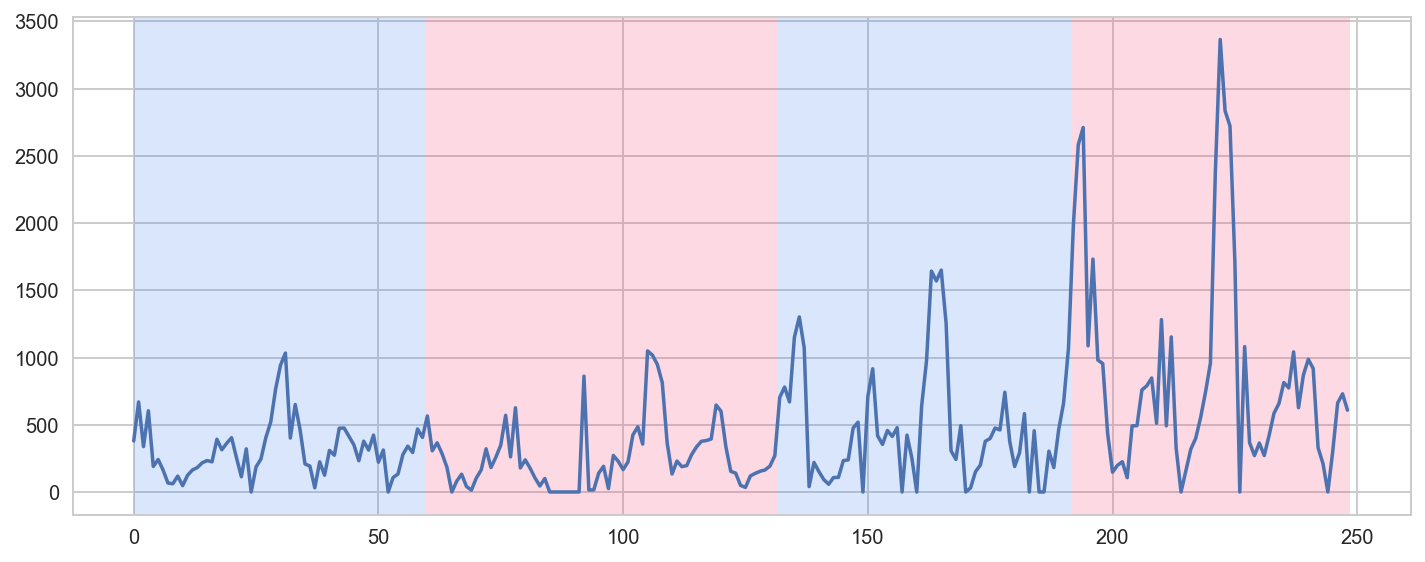

In [94]:
fig, ax = rpt.display(sQty, changepoints, figsize=(10,4))

In [82]:
changepoints

[80, 100, 190, 249]

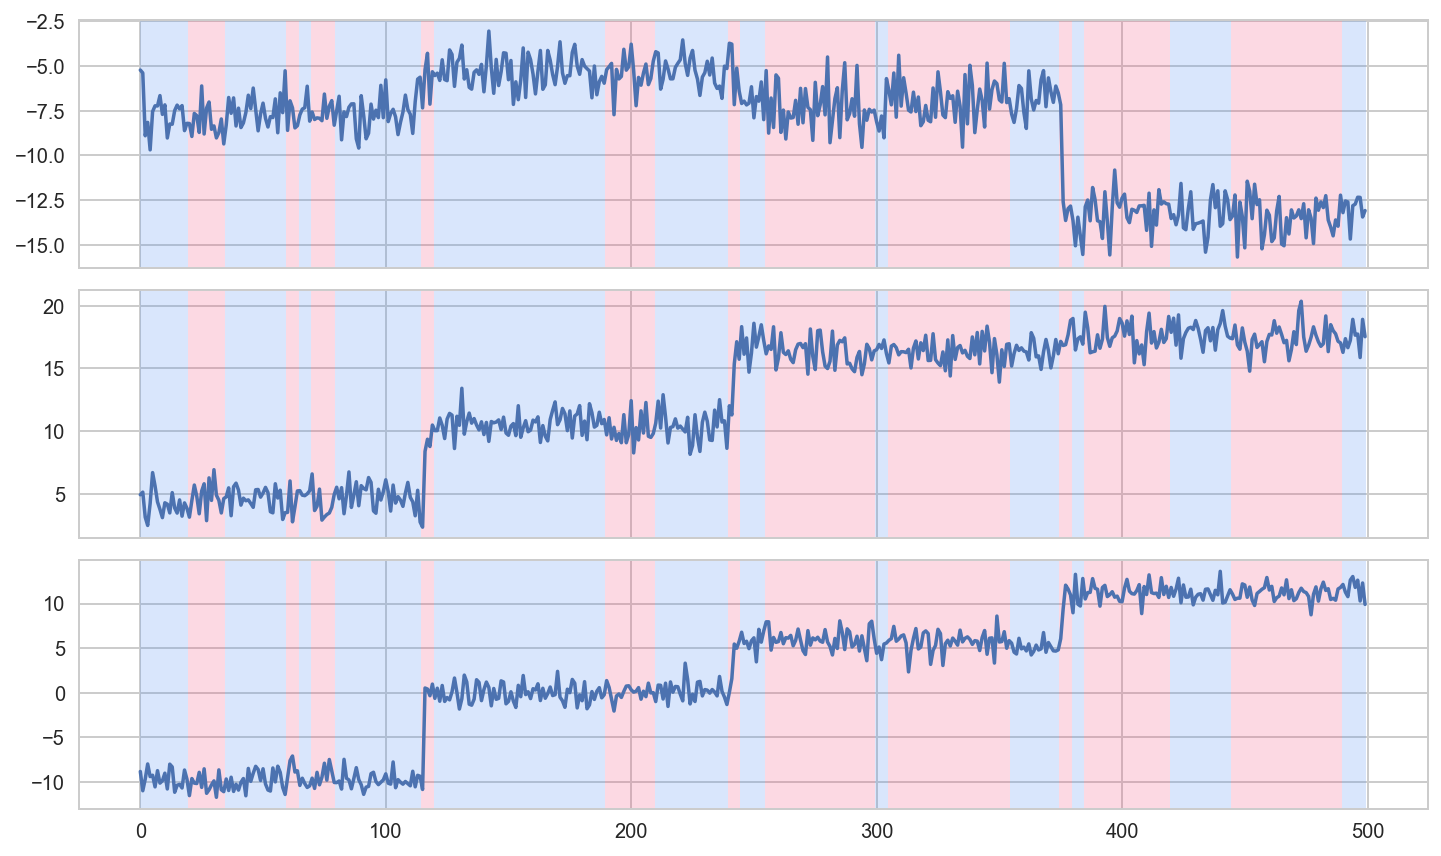

In [73]:
import ruptures as rpt

# creation of data
n, dim = 500, 3
n_bkps, sigma = 3, 1
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(pen=3)

# show results
fig, ax_arr = rpt.display(signal, my_bkps, figsize=(10, 6))
plt.show()

## References
- *otexts.com - [Forecasting: Principles and Practice](https://otexts.com/fpp3/)*
- *laurentoudre.fr - [Selective review of offline change point detection methods](http://www.laurentoudre.fr/publis/TOG-SP-19.pdf)*
- *github.com - [Awesome TS anomaly detection](https://github.com/rob-med/awesome-TS-anomaly-detection)*
- *github.com - [Anomaly detection resources](https://github.com/yzhao062/anomaly-detection-resources#34-time-series-outlier-detection)*
- https://datascience.stackexchange.com/questions/32126/looking-for-a-good-package-for-anomaly-detection-in-time-series
- https://pro.arcgis.com/en/pro-app/2.9/tool-reference/space-time-pattern-mining/how-change-point-detection-works.htm